In [10]:
import math
import scipy
import scipy.io
import scipy.signal as s
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt

import statsmodels.api as sm
#from statsmodels.api import statsmodels.api.nonparametric.smoothers_lowess as sm
import numpy as np

def todB(x): return 10 * np.log10(abs(x))
def amp(x): return 10**(x/10)

def t90(x):
    total = sum(x)
    peak = int(len(x)/2)
    for i in range(1,10000):
        if(sum(x[peak-i:peak+i])>=(0.9*total)):
            return 2*i/fs
    return -99999
    
#   t90(x) gradually increases a symetric window around the peak untill it reaches 90% of the total
#   returns the window size in units of seconds

full = scipy.io.loadmat('23B_121_86_FullGun.mat')
partial = scipy.io.loadmat('23B_123_409_NoGun.mat')

test = scipy.io.loadmat('MGL1212_Line_AT.mat')

f1 = full['Data1']
f2 = full['Data2']

p1 = partial['Data1']
p2 = partial['Data2']

f1=test['Data1']
#f1=f2

f1=np.transpose(f1) #puts data on it's side (easier to work with rows)
#f1=f1[::-1]#reverses 
f1 = f1*(10**6) #convert to micro pascals
fs = 500

In [11]:
# I. High Pass Filter to remove streamer noise

#Applies 3 biquad filters with 11hz cutoff to remove streamer noise, parameters come from fdatool

sos=[[1,-2,1,1,-1.82570619168342,0.881881926844246],[1,-2,1,1,-1.65627993129105,0.707242535896459],[1,-2,1,1,-1.57205200320457,0.620422971870477]]

fData = []
for row in f1:
    fData.append(s.sosfilt(sos,row))
fData=np.asarray(fData)#recast as ndarray


In [12]:
# II. Adjusting for group length (+6dB)
fData = amp(6)*fData # adjusted filtered data

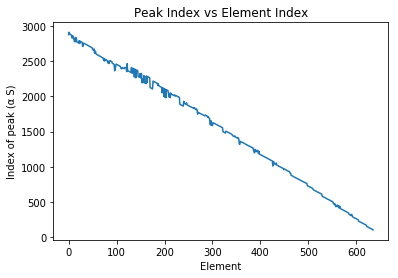

In [13]:
# III. Windowing Around Peak (2s before and after)
peak=[]

#forward 2 s
winData = []#windowed data
for row in fData:
    peak1 = np.argmax(row[0:10*fs])#find peak
    if(peak1>2*fs and peak1<len(row)-2*fs):#unobstructed 4 second window
        DATA = row[peak1-2*fs:peak1+2*fs]#Keep data around the peak (2s before and after)
    elif(peak1>len(row)-2*fs):#Peak is too close to the end
        w = row[peak1-2*fs:end]
        DATA = np.concatenate(w,np.zeros(4*fs-len(w)))
    else:#peak is to close to the begining index
        w = row[peak1:peak1+2*fs]#one-sided window
        DATA = np.concatenate((np.zeros(4*fs-len(w)),w))#pad #check
    winData.append(DATA)
    peak.append(peak1)
winData = np.asarray(winData)#recast as ndarray
plt.plot(peak)
plt.title('Peak Index vs Element Index')
plt.xlabel('Element')
plt.ylabel('Index of peak (α S)')
plt.show()


[ 165.48854915  166.56285724  167.24628429  167.55581522  166.50092356
  167.61589635  167.90615184  166.97765288  167.91454995  166.11984237
  166.84571781  167.3813074   165.80107294  165.9045209   163.31946145
  154.87692443  158.40558258  166.02401478  168.07591969  167.22648878
  167.81579453  167.26846848  169.02246206  167.44315367  168.37123845
  168.22866884  167.69700178  167.99285232  168.24049888  165.38658264
  167.4988507   168.10501385  168.72962378  169.26985244  167.93442446
  168.69235901  169.53749768  169.87629579  169.27131219  169.42334809
  169.72095663  169.07590573  169.10030076  169.21669369  169.64555124
  169.98632863  169.72389749  169.62067762  169.69245117  169.38882736
  169.1082111   169.61913024  169.47079207  169.96557629  168.27901877
  169.4177917   169.84085375  168.79752706  168.51998123  168.78744654
  167.05497081  167.82866492  167.75022222  167.12952221  167.22480172
  166.16723596  166.74076259  166.61481698  166.55160942  166.43143184
  166.

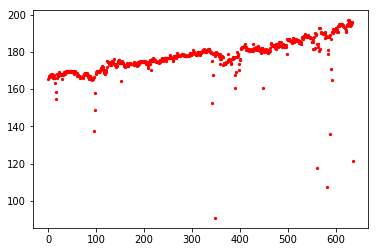

In [14]:
# IV. Calculate RMS of power

squaredPressure = np.multiply(winData,winData)

RMS = []
T90 = []
i = 0

for row in squaredPressure:
    T90a=t90(row)
    RMS.append(10*np.log10(sum(row)/(fs*T90a)))#integrate squared pressure / T90
    i = i+1
    T90.append(T90a)
RMS = np.asarray(RMS)#recast as ndarray
print(RMS)
print(T90)
b = np.linspace(0,len(RMS),len(RMS))
plt.scatter(b,RMS,s=5,c='r')
plt.show()

In [15]:
#IV. Calculate SEL Energy Density (dB)

SEL=[]

i = 0
for rms in RMS:
    SEL.append(rms+10*np.log10(T90[i]))# RMS + log(T90)
    i = i+1
SEL = np.asarray(SEL)#recast as ndarray
print(SEL)

#scipy.io.savemat('Data1.mat', mdict={'SEL':SEL,'RMS':RMS,'Windowed': winData,'Filtered':fData,'Original':f1})#debug

[ 162.58124876  162.95772213  163.87386261  163.99034198  162.97475326
  164.08972606  164.37998155  164.2367692   163.93514986  162.96829599
  163.97221483  164.50780442  163.43535287  163.80032802  159.63389914
  152.74443865  154.59651589  163.71778804  165.5266676   164.70836905
  165.26654244  164.7192164   165.21339537  165.19561627  164.84506815
  164.78005319  164.17083148  164.09945395  164.38947104  163.81267503
  164.88665628  163.94832609  164.34063762  165.06768841  163.63985386
  164.49019498  165.24292708  165.80915646  165.06914816  165.40029995
  165.69790848  165.05285759  165.12090067  165.2372936   165.48886349
  165.64480681  165.38237568  165.18370263  165.20695115  164.95185237
  165.46304857  165.81006355  165.66172538  165.48007627  165.37171838
  165.21562767  165.5927322   165.7872271   165.57861835  165.84608367
  164.07927617  164.88730204  164.80885935  164.5173278   164.85908166
  163.71071931  163.96710181  163.8411562   163.67810643  163.62474471
  163.

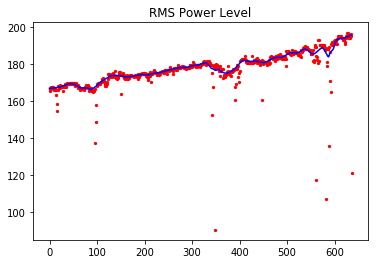

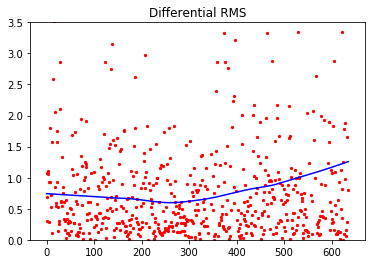

67 channels have been thrown out 
inaccurate: [14, 15, 16, 96, 97, 98, 117, 118, 119, 120, 151, 213, 341, 344, 348, 349, 375, 389, 390, 391, 397, 398, 399, 400, 447, 497, 553, 555, 556, 557, 558, 559, 560, 562, 564, 565, 566, 567, 582, 583, 584, 585, 586, 587, 588, 589, 591, 592, 593, 594, 595, 596, 597, 598, 621, 635] 
noisy: [14, 95, 96, 97, 98, 150, 151, 340, 341, 343, 344, 347, 348, 388, 391, 446, 447, 559, 560, 563, 564, 566, 581, 582, 584, 587, 588, 589, 590, 591, 634, 635]


In [16]:
#V. Remove noisy or inaccurate channels
RMS2=RMS.tolist()
SEL2=SEL.tolist()
RMS_diff=[]
inaccurate=[]
noisy=[]
indexes=[]

N=3
RMS_avg = np.convolve(RMS, np.ones((N,))/N, mode='valid')#rolling average of RMS
RMS_avg = np.concatenate((RMS_avg,RMS[len(RMS_avg):len(RMS_avg)+N-1]))#pad RMS_avg

for i in range(0,len(RMS)-1):
    RMS_diff.append(np.abs(RMS[i]-RMS[i+1]))#differential RMS
RMS_diff.append(999)#add last index and remove it from consideration
RMS_diff_avg = np.convolve(RMS_diff, np.ones((N,))/N, mode='valid')#rolling average of differential RMS
RMS_diff_avg = np.concatenate((RMS_diff_avg,RMS[len(RMS_diff_avg):len(RMS_diff_avg)+N-1]))#pad

b = np.linspace(0,len(RMS),len(RMS))
RMSlowess = sm.nonparametric.lowess(RMS_avg,b,0.05,return_sorted=False)#lowess using 5%
difflowess = sm.nonparametric.lowess(RMS_diff_avg,b,0.5,return_sorted=False)

plt.plot(RMSlowess,c='b')
plt.scatter(b,RMS,s=5,c='r')
plt.title('RMS Power Level')
plt.show()

for i in range(0,len(RMS)):#thresholds were changed, inacurate should be 2
    if(np.abs(RMSlowess[i]-RMS[i])>3):#inacurate 
        inaccurate.append(i)
    if(np.abs(difflowess[i]-RMS_diff[i])>7):#noisy, should be 0.5
        noisy.append(i)        
indexes = np.sort(list(set(np.concatenate((inaccurate,noisy)))))#consolidate
#print(indexes)
for index in sorted(indexes, reverse=True):#remove bad channels
    del RMS2[int(index)]#reversed so that removing doesn't effect the following indexes
    del SEL2[int(index)]

plt.plot(difflowess,c='b')
plt.scatter(b,RMS_diff,s=5,c='r')
plt.ylim([0,3.5])
plt.title('Differential RMS')
plt.show()
print(len(indexes),'channels have been thrown out','\ninaccurate:',inaccurate,'\nnoisy:',noisy)


SEL180 = 12.4875
SEL160 = 12.4875
RMS180 = 12.4875
RMS160 = 12.4875


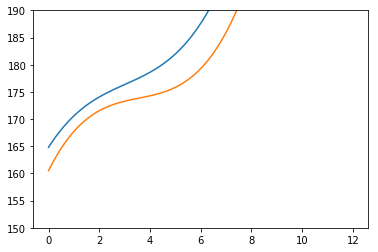

In [17]:
#VI. Fitting Data

b = np.linspace(0,len(RMS2),len(RMS2))
#SELpol = scipy.interpolate.interp1d(b,SEL2,kind='cubic',bounds_error=False,fill_value=True) 
#RMSpol = scipy.interpolate.interp1d(b,RMS2,kind='cubic',bounds_error=False,fill_value=True)
SELpol = np.poly1d(np.polyfit(b,SEL2,3))
RMSpol = np.poly1d(np.polyfit(b,RMS2,3))

#SELpol = InterpolatedUnivariateSpline(b,SEL2,k=5)
#RMSpol = InterpolatedUnivariateSpline(b,RMS2,k=5)

SEL180 = -1
SEL160 = -1
RMS180 = -1
RMS160 = -1

for i in range(0,1000):
    if(SELpol(i)>180):
        SEL180 = i
    if(SELpol(i)>160):
        SEL160 = i
    if(RMSpol(i)>180):
        RMS180 = i
    if(RMSpol(i)>160):
        RMS160 = i
SEL180 = SEL180*(12.5/1000)#converts from index to length in km
SEL160 = SEL160*(12.5/1000)
RMS180 = RMS180*(12.5/1000)
RMS160 = RMS160*(12.5/1000)

print('SEL180 =',SEL180)#Safety radii
print('SEL160 =',SEL160)
print('RMS180 =',RMS180)
print('RMS160 =',RMS160)

#plt.plot(b*12/1000,RMSpol(b))
#plt.plot(b*12/1000,SELpol(b))
plt.plot(np.linspace(0,1000,1000)*12/1000,RMSpol(np.linspace(0,1000,1000)))
plt.plot(np.linspace(0,1000,1000)*12/1000,SELpol(np.linspace(0,1000,1000)))
plt.ylim([150,190])
plt.show()

In [18]:
#Calculate Differential RMS
#winData is windowed data
#RMS.append(10*np.log10(sum(row)/(fs*T90a)))#integrate squared pressure / T90
#diffRMS=[]
#prevrow=winData[0]
#for row in winData:
#    d=np.abs(prevrow-row)
#    diffRMS.append(10*np.log10(sum(d**2)/(T90[i]*fs)))
#    prevrow=row

#plt.plot(diffRMS)
#plt.show()